In [10]:
import math
import numpy as np
from tqdm.notebook import tqdm
# tqdm = lambda x: x

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('legend', title_fontsize=16)
plt.rc('legend', framealpha=0.0)
plt.rc('figure', titlesize=16)
plt.rc('lines', linewidth=3)
plt.rc('figure', figsize = [7,3])

## Get the MNIST data

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, download=True, transform=transform)

def get_data(num_train_examples, num_test_examples, random_labels, binary_digits):

    if binary_digits:
        train_superset = []
        for data in trainset:
            if data[1] < 2:
                train_superset.append( data )
        test_superset = []
        for data in testset:
            if data[1] < 2:
                test_superset.append( data )
    else:
        train_superset = trainset
        test_superset = testset

    indices = np.random.permutation(len(train_superset))[0:num_train_examples]
    train_subset = torch.utils.data.Subset(train_superset, indices)

    indices = np.random.permutation(len(test_superset))[0:num_test_examples]
    test_subset = torch.utils.data.Subset(test_superset, indices)

    if random_labels:
        random_train_subset = []
        for data in train_subset:
            random_train_subset.append( ( data[0], torch.randint(low=0,high=2,size=(1,)).item() ) )
        train_subset = random_train_subset

        random_test_subset = []
        for data in test_subset:
            random_test_subset.append( ( data[0], torch.randint(low=0,high=2,size=(1,)).item() ) )
        test_subset = random_test_subset

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

    return train_loader, test_loader

def normalize_data(data, target):
    data = data.view(data.shape[0],-1)
    data /= data.norm(dim=1).unsqueeze(dim=1)
    data *= math.sqrt(data.shape[1])
    target = target%2*2-1
    return data, target.float()

## Nero optimiser

In [3]:
def neuron_norm(x):
    if x.dim() > 1:
        view_shape = [x.shape[0]] + [1]*(x.dim()-1)
        x = x.view(x.shape[0],-1)
        return x.norm(dim=1).view(*view_shape)
    else:
        return x.abs()

def neuron_mean(x):
    if x.dim() > 1:
        view_shape = [x.shape[0]] + [1]*(x.dim()-1)
        x = x.view(x.shape[0],-1)
        return x.mean(dim=1).view(*view_shape)
    else:
        raise Exception("neuron_mean not defined on 1D tensors.")

class Nero(Optimizer):

    def __init__(self, params, lr=0.01, beta=0.999, constraints=True):
        self.beta = beta
        self.constraints = constraints
        defaults = dict(lr=lr)
        super(Nero, self).__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                if self.constraints and p.dim() > 1:
                    p.data -= neuron_mean(p)
                    p.data /= neuron_norm(p)
                state = self.state[p]
                state['step'] = 0
                state['exp_avg_sq'] = torch.zeros_like(neuron_norm(p))
                state['scale'] = neuron_norm(p).mean()
                if state['scale'] == 0.0:
                    state['scale'] = 0.01

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]

                state['step'] += 1
                bias_correction = 1 - self.beta ** state['step']
                state['exp_avg_sq'] = self.beta * state['exp_avg_sq'] + (1-self.beta) * neuron_norm(p.grad)**2

                grad_normed = p.grad / (state['exp_avg_sq']/bias_correction).sqrt()
                grad_normed[torch.isnan(grad_normed)] = 0
                
                p.data -= group['lr'] * state['scale'] * grad_normed

                if self.constraints and p.dim() > 1:
                    p.data -= neuron_mean(p)
                    p.data /= neuron_norm(p)

        return loss

## Create network trainer

In [4]:
class SimpleNet(nn.Module):
    def __init__(self, depth, width):
        super(SimpleNet, self).__init__()

        self.initial = nn.Linear(784, width, bias=False)
        self.layers = nn.ModuleList([nn.Linear(width, width, bias=False) for _ in range(depth-2)])
        self.final = nn.Linear(width, 1, bias=False)

    def forward(self, x):
        x = self.initial(x)
        x = F.relu(x) * math.sqrt(2)
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x) * math.sqrt(2)
        return self.final(x)


def train_network(train_loader, test_loader, depth, width, init_lr, decay, target_scale, gauss_target):
    
    model = SimpleNet(depth, width).cuda()
    optim = Nero(model.parameters(), lr=init_lr)
    lr_lambda = lambda x: decay**x
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

    data, target = next(iter(train_loader))
    data, target = (data.cuda(), target.cuda())
    data, target = normalize_data(data, target)

    if gauss_target:
        target *= torch.randn_like(target).abs()

    train_acc_list = []
    train_acc = 0

    model.train()

    for epoch in range(500):

        y_pred = model(data).squeeze()
        loss = (y_pred - target_scale*target).norm()

        model.zero_grad()
        loss.backward()
        optim.step()

        correct = (target.sign() == y_pred.sign()).sum().item()
        total = target.shape[0]
        train_acc_list.append(correct/total)

        lr_scheduler.step()

    # print( "final training RMS error:", loss.item()/math.sqrt(total) )

    model.eval()
    
    data, target = next(iter(test_loader))
    data, target = (data.cuda(), target.cuda())
    data, target = normalize_data(data, target)
        
    y_pred = model(data).squeeze()
    correct = (target == y_pred.sign()).sum().item()
    total = target.shape[0]

    test_acc = correct/total

    return train_acc_list, test_acc, y_pred.detach()

## Implement the NNGP kernel

In [5]:
def sanitise(sigma):
    return sigma.clamp(min=-1,max=1)

def increment_kernel(sigma):
    new_sigma = (1-sigma**2).sqrt()
    new_sigma += sigma*(math.pi - sigma.acos())
    new_sigma /= math.pi
    return sanitise(new_sigma)

## Compare NN and GP averaging

In [6]:
print("\nGetting data...")

### Dependent variables
num_test_examples = 10000
random_labels = False
binary_digits = False
depth = 5
width = 2048
num_train_examples = 1000

num_voters_list = [1,2,4,8,16]
scale_list = np.logspace(-3, 1, num=20)

### Finite width NN hyperparameters
init_lr = 0.01
decay = 0.99

### Set random seed
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

data = get_data( num_train_examples=num_train_examples,
                num_test_examples=num_test_examples,
                random_labels=random_labels, 
                binary_digits=binary_digits )

train_loader, test_loader = data

print("\nCompute kernel")

train_data, train_target = list(train_loader)[0]
test_data, test_target = list(test_loader)[0]

data = torch.cat((train_data, test_data), dim=0)
target = torch.cat((train_target, test_target), dim=0)

data, target = data.cuda(), target.cuda()
data, target = normalize_data(data, target)

sigma = sanitise(torch.mm(data, data.t()) / data.shape[1]).cpu()
assert ( sigma == sigma.t() ).all()

for _ in range(depth-1):
    sigma = increment_kernel(sigma)
    assert ( sigma == sigma.t() ).all()

sigma_bb = sigma[:num_train_examples, :num_train_examples]
sigma_ab = sigma[num_train_examples:, :num_train_examples]
sigma_ba = sigma[:num_train_examples, num_train_examples:]
sigma_aa = sigma[num_train_examples:, num_train_examples:]

x_b = target[:num_train_examples].float().cpu()
x_a = target[num_train_examples:].float().cpu()

sigma_bb_inv = torch.cholesky_inverse(torch.cholesky(sigma_bb))

cond_mu = sigma_ab @ sigma_bb_inv @ x_b
cond_sigma = torch.diag(sigma_aa - sigma_ab @ sigma_bb_inv @ sigma_ba).sqrt()

results = {}

for num_voters in num_voters_list:
    print("num averagers", num_voters)

    nn_gibbs_list = []
    nn_aver_list = []

    gp_gibbs_list = []
    gp_aver_list = []

    for scale in tqdm(scale_list):

        ## NN stuff
        
        voter_acc_list = []
        running_average = None

        for voter in range(num_voters):
            nn_train_acc, nn_test_acc, pred = train_network(train_loader, test_loader, depth, width, init_lr, decay, target_scale=scale, gauss_target=False)
            voter_acc_list.append(nn_test_acc)
            if running_average is None:
                running_average = pred
            else:
                running_average += pred
        nn_gibbs_acc = np.mean(voter_acc_list)
        nn_aver_acc = ( x_a==running_average.sign().cpu() ).sum() * 1.0 / num_test_examples
        
        nn_gibbs_list.append(nn_gibbs_acc)
        nn_aver_list.append(nn_aver_acc)
        
        ## GP stuff

        cond_mu_scale = cond_mu * scale

        pred_noise = torch.randn(num_voters, num_test_examples) * cond_sigma
        pred = ( cond_mu_scale + pred_noise ).t()
        
        pred_average = pred.sum(dim=1).sign()
        ensemble_acc = (x_a == pred.sign().t()).sum(dim=1) * 1.0 / num_test_examples

        gp_aver_acc = (x_a == pred_average).sum() * 1.0 / num_test_examples
        gp_gibbs_acc = ensemble_acc.mean()

        gp_gibbs_list.append(gp_gibbs_acc)
        gp_aver_list.append(gp_aver_acc)
        
    results[num_voters] = (nn_gibbs_list, nn_aver_list, gp_gibbs_list, gp_aver_list)


Getting data...

Compute kernel
num averagers 1



num averagers 2



num averagers 4



num averagers 8



num averagers 16


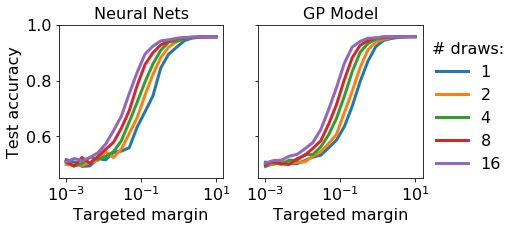

In [17]:
fig, ax = plt.subplots(1, 2)

for num_voters in num_voters_list:
    nn_gibbs_list, nn_aver_list, gp_gibbs_list, gp_aver_list = results[num_voters]
    
    ax[0].plot(scale_list, nn_aver_list, label=num_voters)
    ax[1].plot(scale_list, gp_aver_list, label=num_voters)
#     ax[0].plot(scale_list, gp_aver_list, label=num_voters, color='black', linestyle='dotted')

for axis in [ax[0],ax[1]]:
    axis.set_xscale('log')
    axis.set_ylim(0.45,1.0)
    axis.set_xlabel('Targeted margin')
    axis.set_xticks([1e-3,1e-1,1e1])

ax[0].set_ylabel('Test accuracy')
ax[0].set_title("Neural Nets")
ax[1].set_title("GP Model")
ax[1].axes.yaxis.set_ticklabels([])
ax[1].legend(loc=(1.02,0.0), title="# draws:")

plt.tight_layout(pad=0, w_pad=1.08)
plt.savefig('ensemble.pdf')
plt.show()